### Análisis Summary vs. Ref. Summary: Indistinguibilidad y la Correlación con Métricas de Evaluación
---

In [1]:
import time
import shap
import optuna 

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from src.evaluation import EvalSummMetrics
from src.data_visualization import (
    plot_fraction_preferred_to_ref,
    plot_metrics_by_algorithm_and_complexity,
    plot_metrics_by_fraction_preferred_to_ref,
    visualize_correlation,
)

from data.policy_data import policy_dict

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Eval Summ metrics
eval_summ_metrics = EvalSummMetrics(policy_dict)

---

### Con este análisis se responde a la pregunta:
- **RQ2: ¿Son aquellos resúmenes generados por modelos más complejos (arquitectura / número de parámetros), propios del contexto actual, indistinguibles de resúmenes de referencia o incluso mejores?**

---

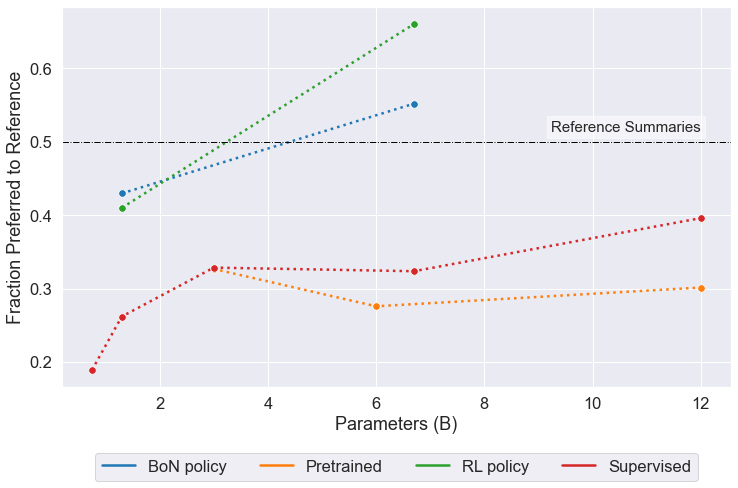

In [39]:
# Plot fraction preferred to ref
plot_fraction_preferred_to_ref(
    eval_summ_metrics.fraction_preferred_to_ref,
    "figs/fraction_preferred_to_ref_vs_model_type",
)

---

### Observación de las relaciones monótonas entre el grado de preferencia sobre las referencias y  el valor de las métricas de evaluación. Aquí se responde a la pregunta:
- **RQ1: ¿Son válidas las métricas de evaluación tradicionales (ROUGE, BLEU) en el contexto actual, en el cual el evaluador no es capaz de distinguir resúmenes automáticos de resúmenes de referencia (juicio humano)?**

A continuación se muestra el análisis de `correlación` entre las `preferencias humanas` y las `métricas de evaluación`, se han considerado dos escenarios diferentes para estudiar cómo se alinean estos dos aspectos.

- `Primer Escenario (Restricción de Muestra)`: En el primer escenario, se han **excluido las políticas de Aprendizaje por Refuerzo (RL) y BoN**, **enfocándose** en aquellos casos en los que la fracción preferida en referencia a los resúmenes automáticos es menor al 40%. Este escenario permite estudiar la correlación en **situaciones en las que los resúmenes generados** por los modelos no son altamente preferidos en comparación con los resúmenes de referencia. Esto podría revelar cómo las métricas de evaluación tradicionales se comportan cuando los resúmenes generados **son menos óptimos** o coherentes con las expectativas humanas.

- `Segundo Escenario (Muestra Completa)`: En el segundo escenario, se considera la muestra completa sin ninguna exclusión de políticas o restricciones en la fracción preferida. Esto ofrece una visión más global y comprensiva de cómo las métricas de evaluación se correlacionan con las preferencias humanas en todo el espectro de calidad de resúmenes. Este análisis puede proporcionar una comprensión más profunda de la alineación o desalineación entre las métricas y el juicio humano, destacando potenciales áreas donde las métricas actuales puedan fallar en capturar la calidad percibida por los evaluadores humanos.

Ambos escenarios son fundamentales para comprender cómo las métricas de evaluación interactúan con las preferencias humanas, y pueden arrojar luz sobre la eficacia de las métricas actuales en diferentes contextos de generación de resúmenes automáticos. La restricción en el primer escenario permite aislar y examinar casos particulares, mientras que la inclusión completa en el segundo escenario proporciona una imagen más generalizada de la correlación en estudio.

---

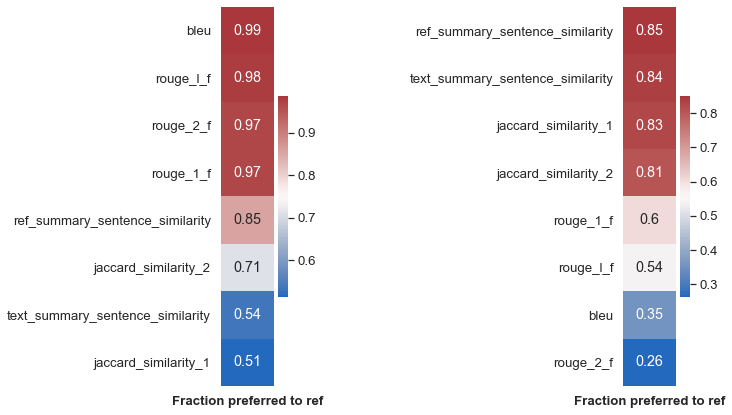

In [29]:
# Plot correlation between human preferences and metrics
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

visualize_correlation(
    eval_summ_metrics.metrics_df.loc[eval_summ_metrics.metrics_df["Fraction preferred to ref"] < 0.4, eval_summ_metrics.metrics], 
    eval_summ_metrics.metrics_df.loc[eval_summ_metrics.metrics_df["Fraction preferred to ref"] < 0.4, ["Fraction preferred to ref"]], 
    "Fraction preferred to ref",
    ax=axes[0],
)

visualize_correlation(
    eval_summ_metrics.metrics_df[eval_summ_metrics.metrics], 
    eval_summ_metrics.metrics_df[["Fraction preferred to ref"]], 
    "Fraction preferred to ref",
    ax=axes[1],
)

plt.tight_layout()
plt.subplots_adjust(wspace=5)
plt.savefig("figs/summ_to_ref_summ_preferred_corr_evolution.png", bbox_inches='tight')
plt.show()


---

A continuación, se presentan dos análisis punto a punto representados en gráficos:
1. `Complejidad del algoritmo (número de parámetros / arquitectura / entrenamiento)` frente a `valor de las métricas de evaluación`.
2. `Grado de Preferencia sobre la Referencia` frente a `valor de las métricas de evaluación`.

En este contexto, el término "Grado de Preferencia sobre la Referencia" se refiere a la proporción o porcentaje de veces que un resumen generado automáticamente es preferido en comparación con un resumen de referencia creado por un humano. Los evaluadores humanos **comparan** ambos resúmenes y eligen cuál prefieren en términos de calidad, coherencia, cobertura, etc.

Entre los dos gráficos propuestos, el segundo es, sin lugar a dudas, el más informativo, ya que compara directamente las preferencias humanas con las métricas de evaluación. 

Resulta interesante observar cómo:
- métricas de referencia como `ROUGE` y `BLEU` están muy alineadas con las preferencias humanas, pero solo cuando la calidad de los resúmenes generados está por debajo del `40%` de preferencia. Esto suele coincidir con aquellos modelos menos sofisticados. 
- Por otro lado, algunas métricas que parecían menos explicativas con la muestra reducida (grado de preferencia < `40%`) se vuelven las más informativas cuando se examina toda la muestra, demostrando ser más robustas.

---


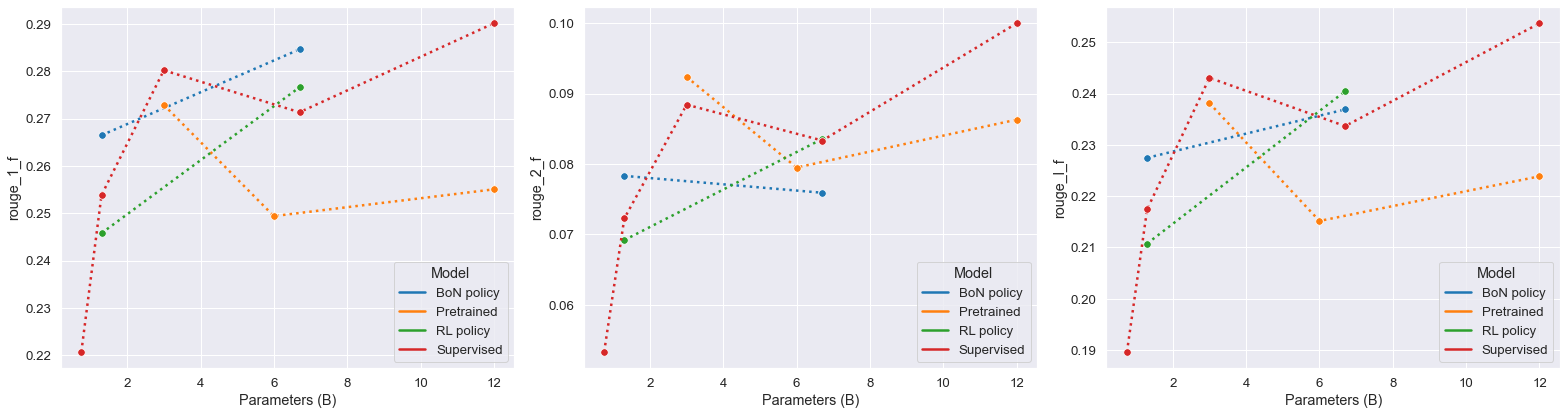

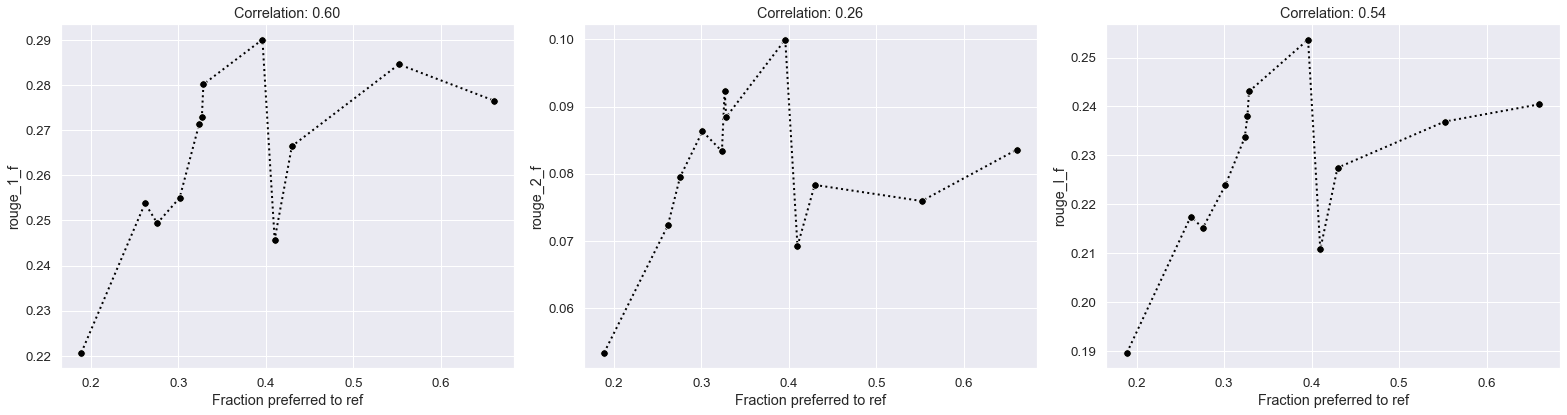

In [34]:
plot_metrics_by_algorithm_and_complexity(
    eval_summ_metrics, 
    ['rouge_1_f', 'rouge_2_f', 'rouge_l_f'],
    "figs/rouge_vs_model_type",    
)

plot_metrics_by_fraction_preferred_to_ref(
    eval_summ_metrics, 
    ['rouge_1_f', 'rouge_2_f', 'rouge_l_f'],
    "figs/rouge_vs_fraction_preferred_to_ref",
)

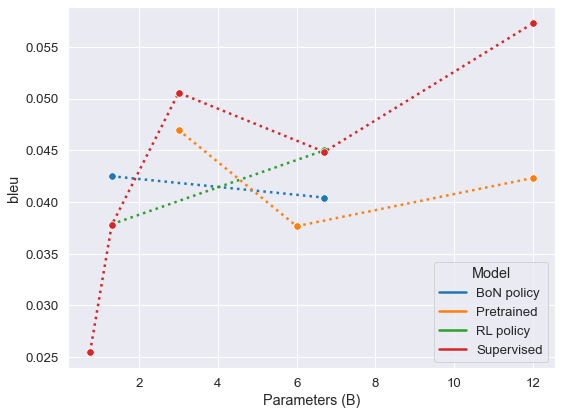

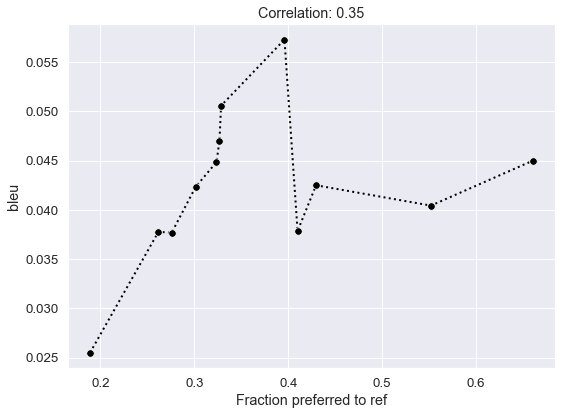

In [35]:
plot_metrics_by_algorithm_and_complexity(
    eval_summ_metrics, 
    ['bleu'],
    "figs/bleu_vs_model_type",       
)

plot_metrics_by_fraction_preferred_to_ref(
    eval_summ_metrics, 
    ['bleu'],
    "figs/bleu_vs_fraction_preferred_to_ref"    
)

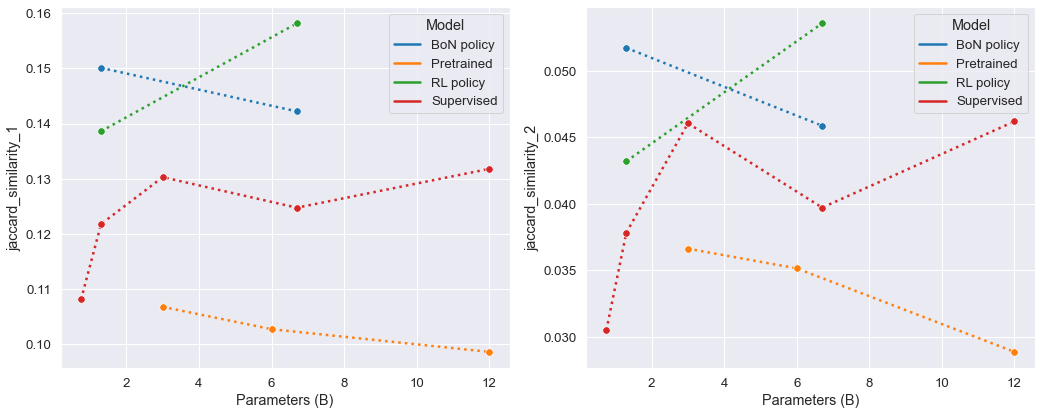

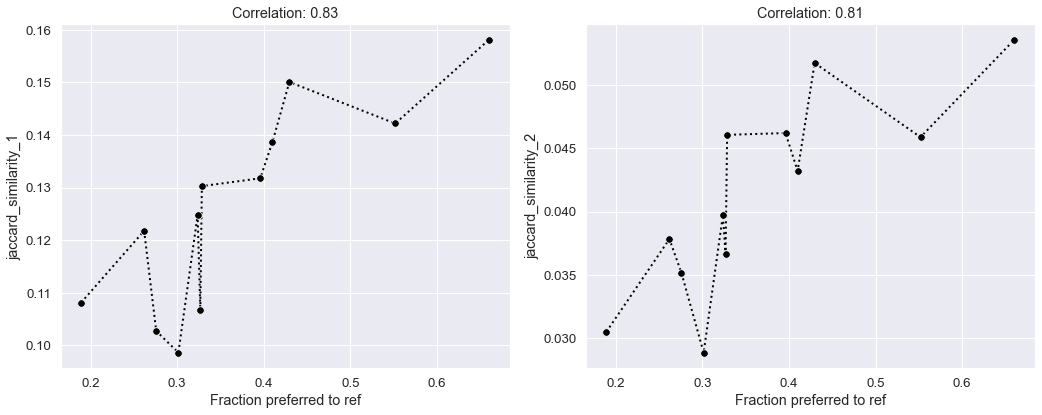

In [36]:
plot_metrics_by_algorithm_and_complexity(
    eval_summ_metrics, 
    ['jaccard_similarity_1', 'jaccard_similarity_2'],
    "figs/jaccard_similarity_vs_model_type",      
)

plot_metrics_by_fraction_preferred_to_ref(
    eval_summ_metrics, 
    ['jaccard_similarity_1', 'jaccard_similarity_2'],
    "figs/jaccard_similarity_vs_fraction_preferred_to_ref",
)

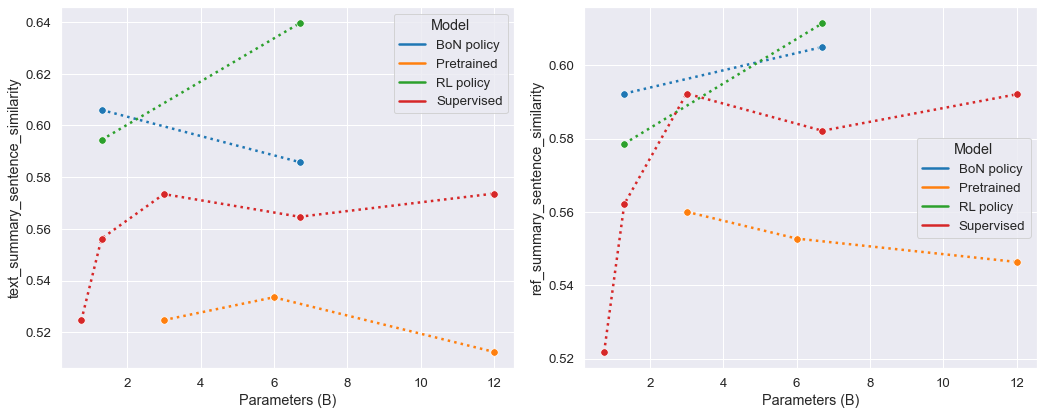

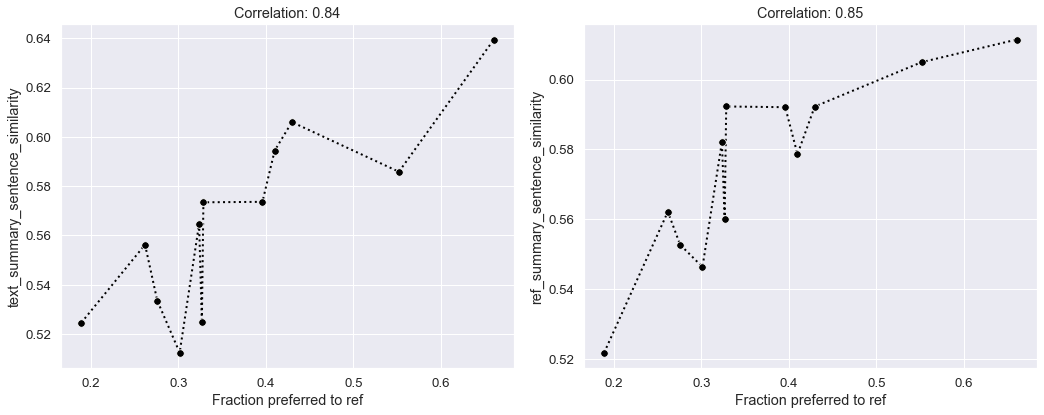

In [37]:
plot_metrics_by_algorithm_and_complexity(
    eval_summ_metrics, 
    ['text_summary_sentence_similarity', 'ref_summary_sentence_similarity'],
    "figs/sentence_similarity_vs_model_type",          
)

plot_metrics_by_fraction_preferred_to_ref(
    eval_summ_metrics, 
    ['text_summary_sentence_similarity', 'ref_summary_sentence_similarity'],
    "figs/sentence_similarity_vs_fraction_preferred_to_ref",    
    
)

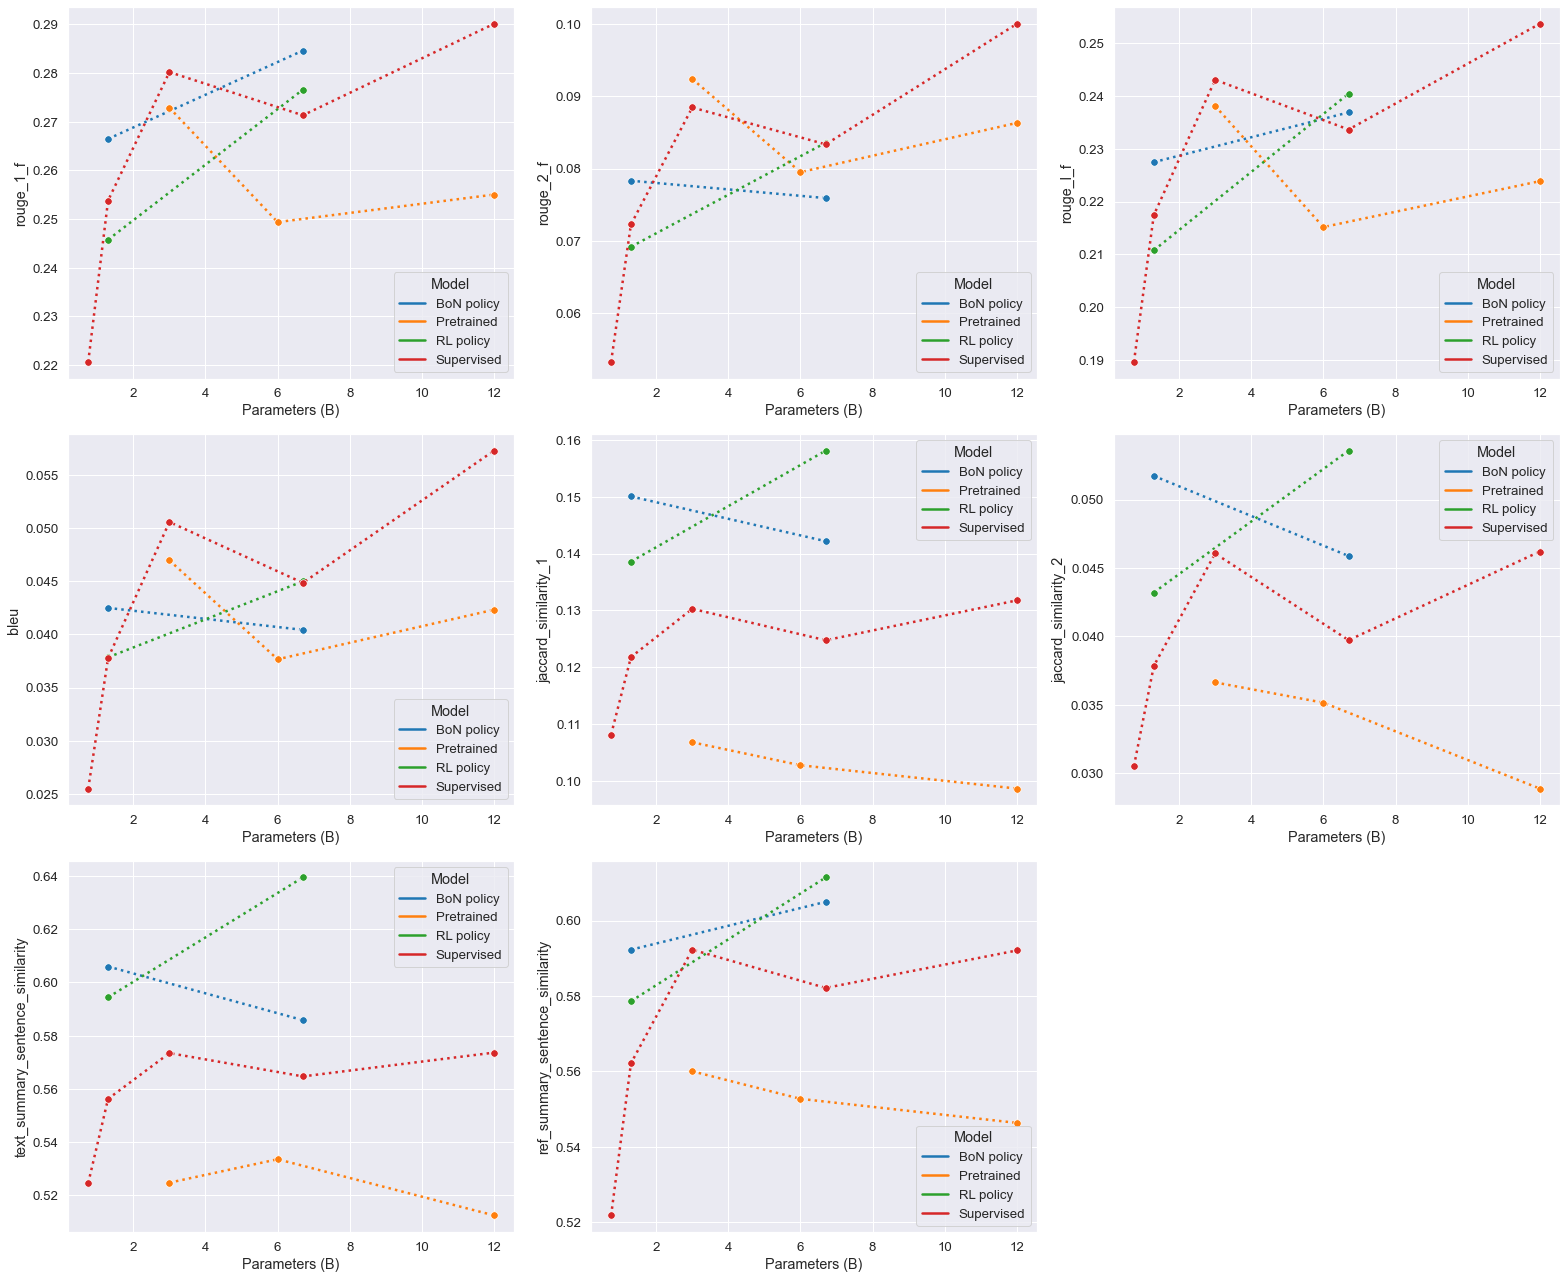

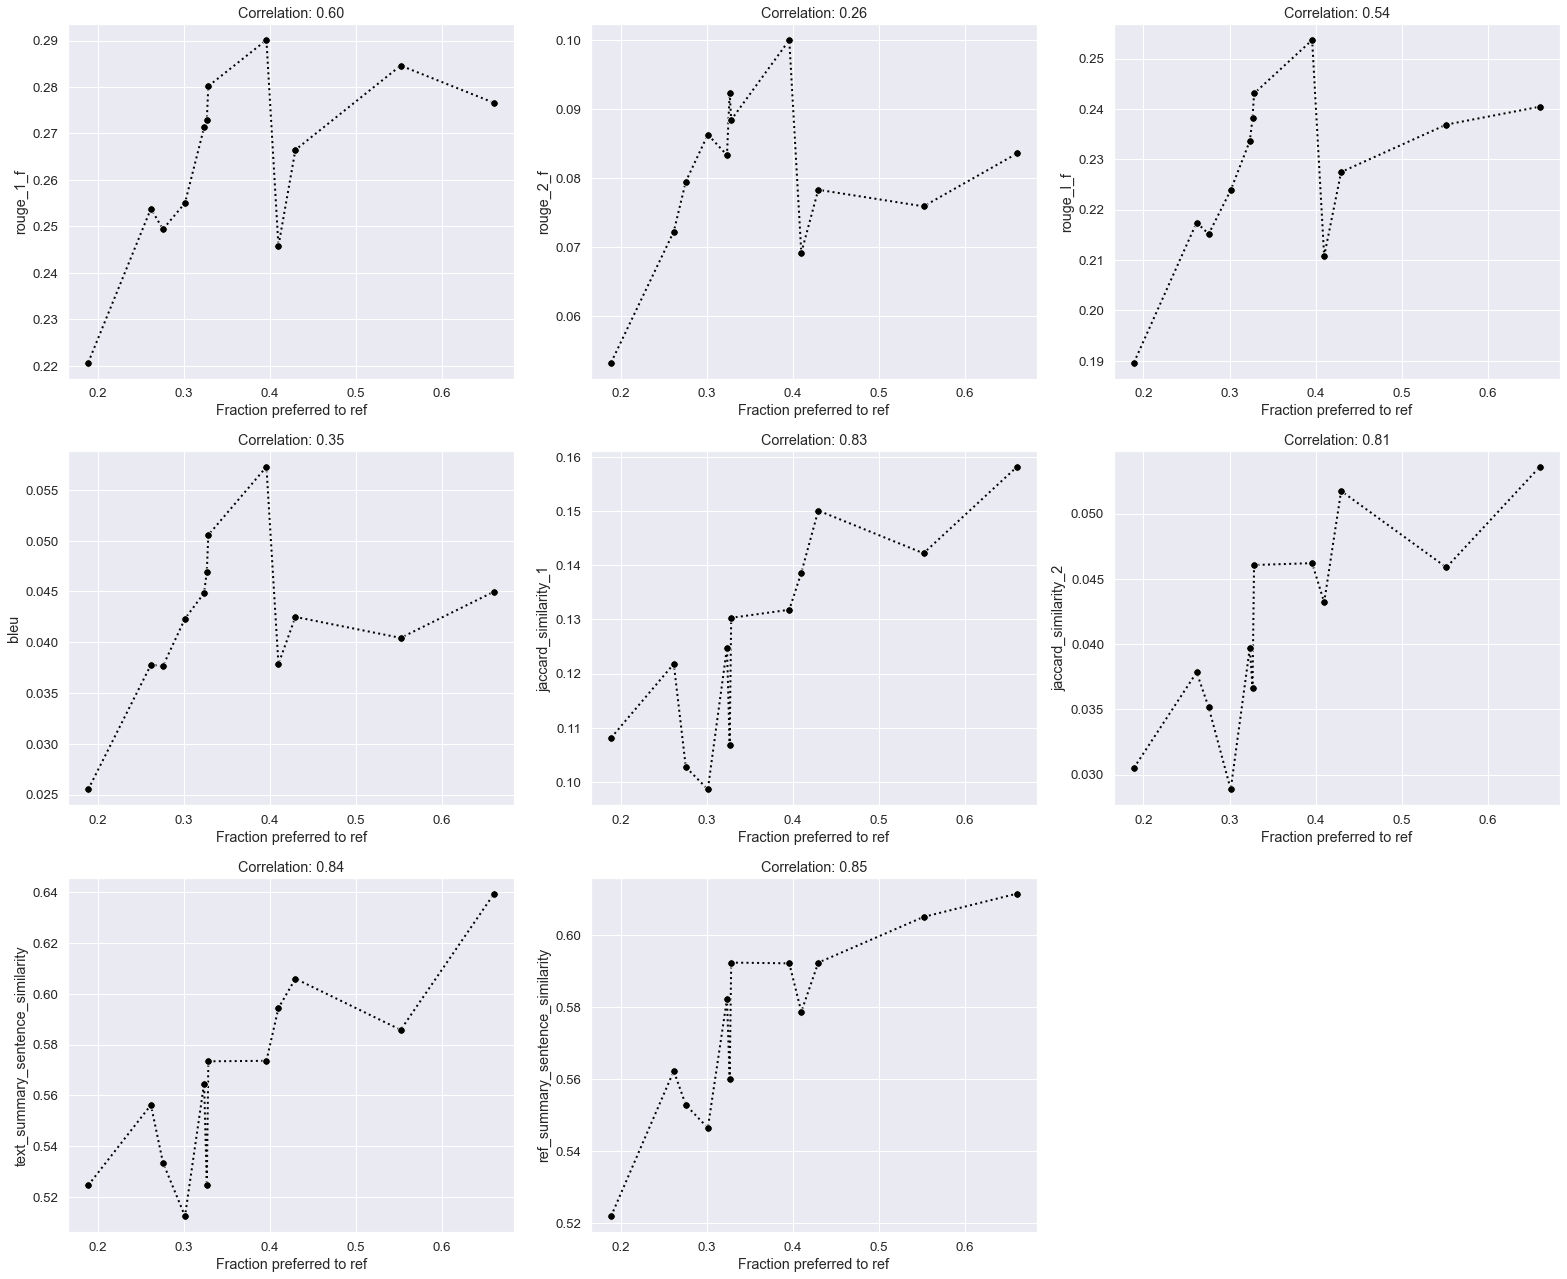

In [38]:
plot_metrics_by_algorithm_and_complexity(
    eval_summ_metrics, 
    eval_summ_metrics.metrics,
    "figs/summ_metrics_vs_model_type",       
)

plot_metrics_by_fraction_preferred_to_ref(
    eval_summ_metrics, 
    eval_summ_metrics.metrics,
    "figs/summ_metrics_vs_fraction_preferred_to_ref", 
)